<h1><center> Freesound General-Purpose Audio Tagging Challenge </center></h1>

<center><img src='https://upload.wikimedia.org/wikipedia/commons/3/3c/Freesound_project_website_logo.png'></center>

https://www.kaggle.com/c/freesound-audio-tagging

<div style="text-align: justify"> You’re challenged to build a general-purpose automatic audio tagging system using a dataset of audio files covering a wide range of real-world environments. Sounds in the dataset include things like musical instruments, human sounds, domestic sounds, and animals from Freesound’s library, annotated using a vocabulary of more than 40 labels from Google’s AudioSet ontology. To succeed in this competition your systems will need to be able to recognize an increased number of sound events of very diverse nature, and to leverage subsets of training data featuring annotations of varying reliability (see Data section for more information). </div>

You can use Kaggle API to download the files:
```bash
kaggle competitions download -c freesound-audio-tagging
```

This notebook has ideas and learning from [this](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data) kernel in specific - thanks to Fizzbuzz.

<h1><center><span style="color:#8C0A04">1. Exploratory Data Analysis </span></center></h1>

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.io import wavfile
import IPython.display as ipd

### 1.1 Loading Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


### 1.2 Checking out Training Data

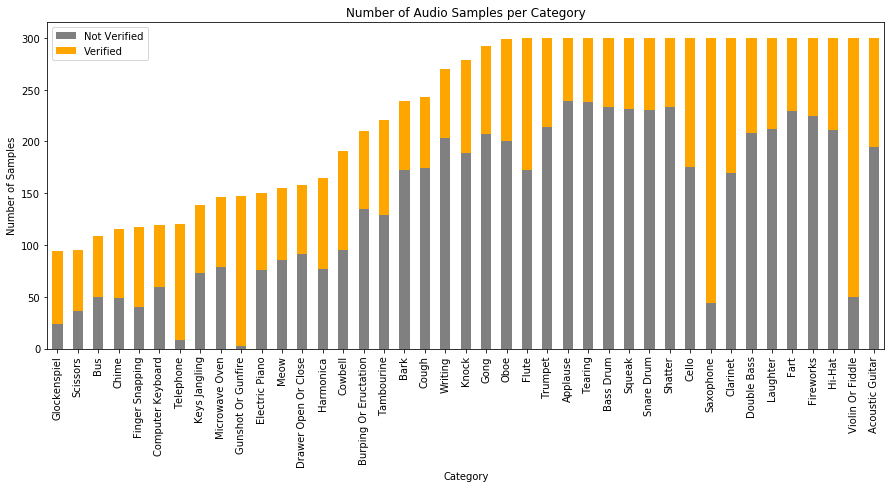

# of Categories: 41
Minimum Samples per Category: 94
Maximum Samples per Category: 300


In [4]:
train.loc[:,'label'] = train.label.apply(lambda x: ' '.join(x.split('_')).title())

n_classes = train.label.nunique()

category_group = train.groupby(['label', 'manually_verified']).count()
category_group = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)
category_group.plot(kind='bar', stacked=True, figsize=(15,6), color=['gray', 'orange'])

plt.title('Number of Audio Samples per Category')
plt.legend(['Not Verified', 'Verified'])
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

print(f'# of Categories: {n_classes}')
print(f'Minimum Samples per Category: {min(train.label.value_counts())}')
print(f'Maximum Samples per Category: {max(train.label.value_counts())}')

We observe that:

**1.** The number of audio samples per category is non-uniform. The minimum number of audio samples in a category is 94 while the maximum is 300

**2.** Also, the proportion of manually verified labels per category is non-uniform.

---

### 1.3 Reading Audio Files

The audios are [pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz.

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-Depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Sampling Rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array.

In [11]:
audio_sample = train.sample()
fname = 'audio_train/' + audio_sample.fname.values[0]
print(f'Audio Label: {audio_sample.label.values[0]}')
ipd.Audio(fname)

Audio Label: Double Bass


Sampling Rate = 44100 Hz
Total Samples = 85554
Duration = 1.94 s


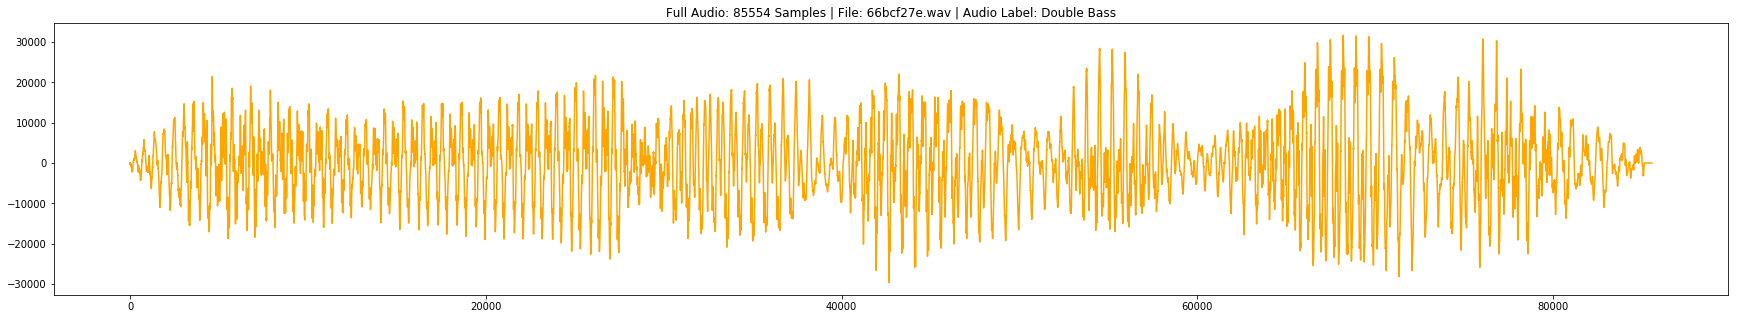

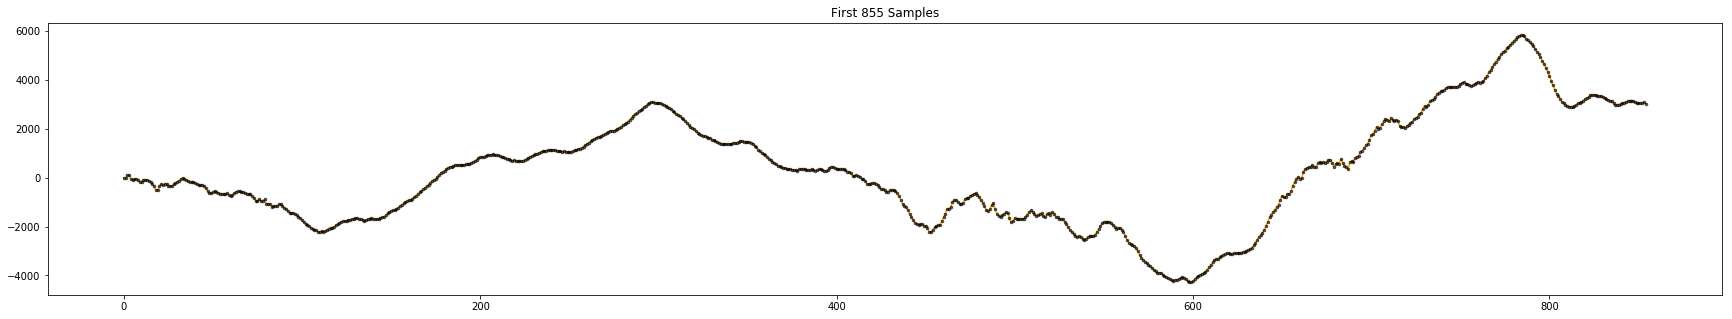

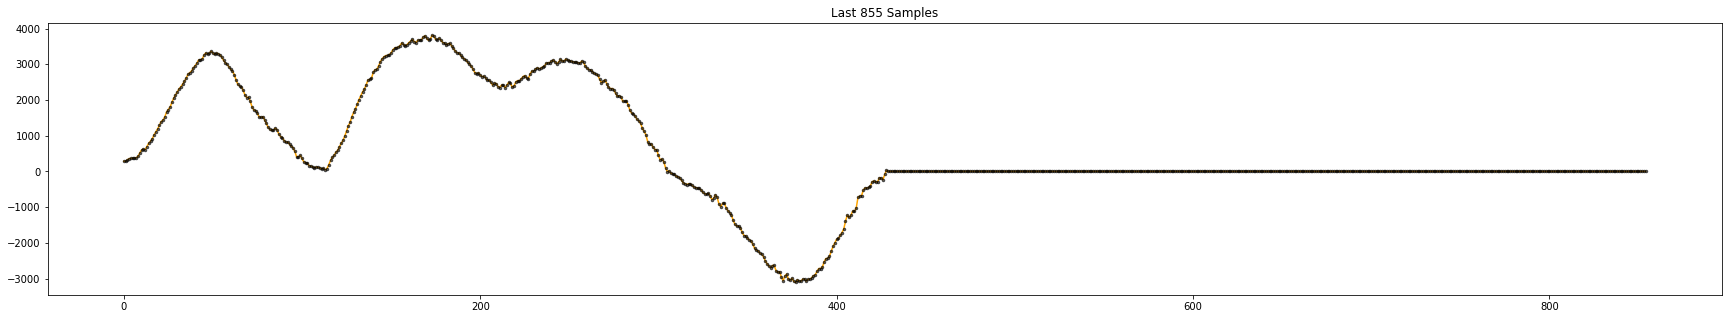

In [12]:
sample_rate, data = wavfile.read(fname)
print(f'Sampling Rate = {sample_rate} Hz')
print(f'Total Samples = {len(data)}')
print(f'Duration = {len(data)/sample_rate} s')

n_points = len(data)//100

plt.figure(figsize=(30,5))
plt.title(f'Full Audio: {len(data)} Samples | File: {audio_sample.fname.values[0]} | Audio Label: {audio_sample.label.values[0]}')
plt.plot(data, color='orange')

plt.figure(figsize=(30,5))
plt.title(f'First {n_points} Samples')
plt.plot(data[:n_points], '-', color='orange')
plt.plot(data[:n_points], '.', color='black', markersize=5, alpha=.6);

plt.figure(figsize=(30,5))
plt.title(f'Last {n_points} Samples')
plt.plot(data[len(data)-n_points:], '-', color='orange')
plt.plot(data[len(data)-n_points:], '.', color='black', markersize=5, alpha=.6);

### 1.4 Lenght and Amplitude Distribution

In [7]:
train.loc[:,'data'] = train.fname.apply(lambda x: wavfile.read('audio_train/'+x)[1])

To make an analysis on the amplitude of each signal we can calculate the RMS Amplitude. It's given by:
$$A_{RMS} = \sqrt{\dfrac{\sum_{i=0}^nx_n}{n}}$$

In [17]:
train.loc[:,'rms_amplitude'] = train.data.apply(lambda x: np.sqrt((np.array(x, dtype='int64')**2).sum()/len(x)))

In [18]:
train.loc[:,'total_samples'] = train.data.apply(lambda x: len(x))
train.loc[:,'duration(s)']   = train.total_samples/sample_rate

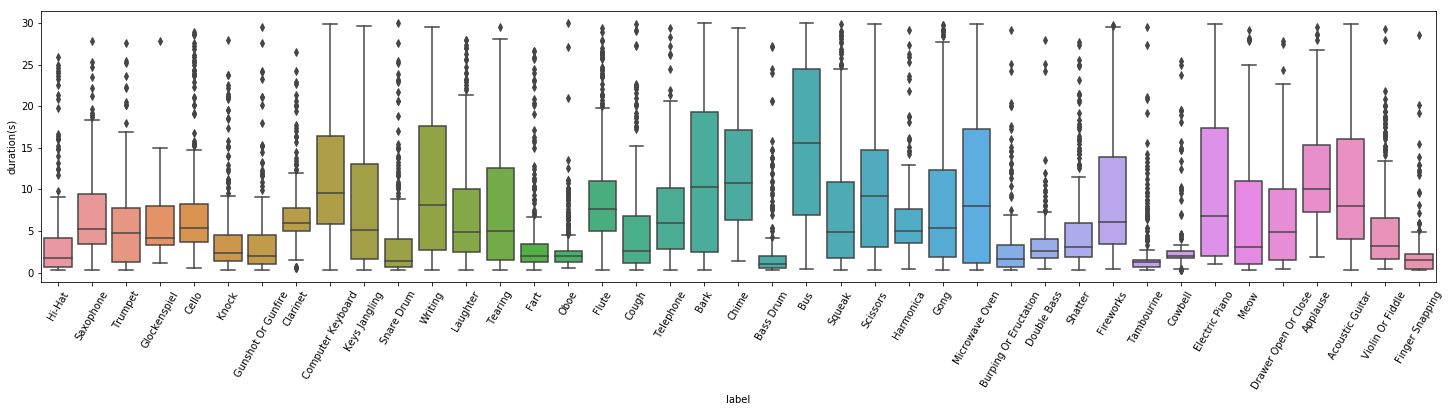

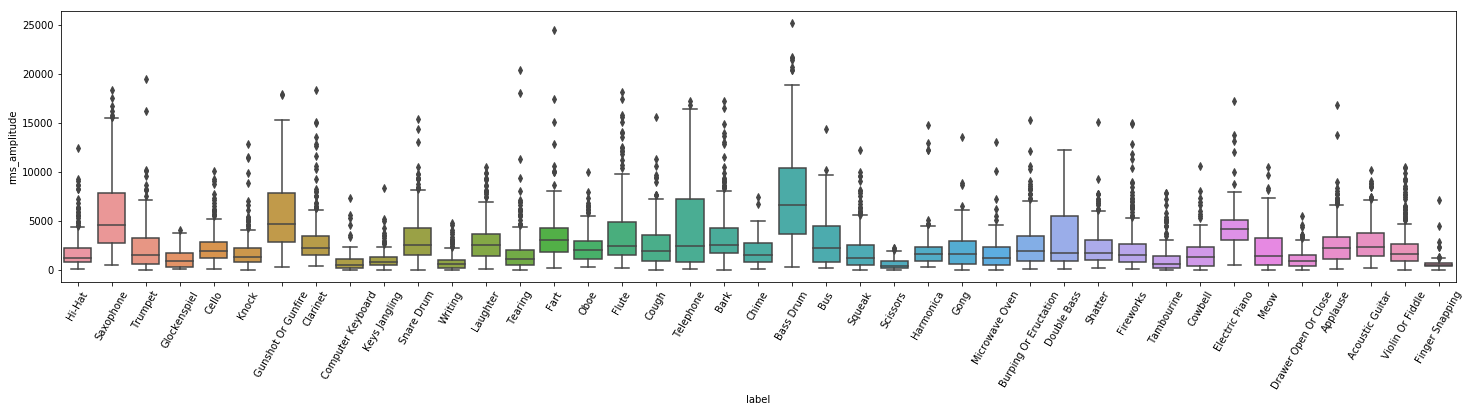

In [19]:
plt.figure(figsize=(25,5))
sns.boxplot(x='label', y='duration(s)', data=train)
plt.xticks(rotation=60)

plt.figure(figsize=(25,5))
sns.boxplot(x='label', y='rms_amplitude', data=train)
plt.xticks(rotation=60)
plt.show()

In [20]:
# test.loc[:,'data']  = test.fname.apply(lambda x: wavfile.read('audio_test/'+x)[1])
# test.loc[:,'label'] = test.label.apply(lambda x: ' '.join(x.split('_')).title())
# test.loc[:,'total_samples'] = test.data.apply(lambda x: len(x))
# test.loc[:,'duration(s)']   = test.total_samples/sample_rate
# test.loc[:,'rms_amplitude'] = test.data.apply(lambda x: np.sqrt((np.array(x, dtype='int64')**2).sum()/len(x)))

---

<h1><center><span style="color:#8C0A04">2. Creating the Model </span></center></h1>

As a first approach, we are going to use the combination of Convolutional Neural Networks (CNN) with the Mel Frequency Cepstral Coefficients (MFCC). If we just want to classify some sound, we should build features that are speaker independent. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale.

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

In [ ]:
import librosa
SAMPLE_RATE = 44100
fname = '/audio_train/' + '00044347.wav'
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape
plt.imshow(mfcc, cmap='hot', interpolation='nearest');